In [1]:
# Base code

import tensorflow as tf
# Keras: 텐서플로우 모델을 만들고 훈련할 수 있는 고수준 API

print(tf.__version__)

from tensorflow import keras
# Keras: 텐서플로우 모델을 만들고 훈련할 수 있는 고수준 API

import numpy as np
import matplotlib.pyplot as plt

2.2.0


In [2]:
import os

In [3]:
base_dir = '..\Flag_Data'
train_dir = os.path.join(base_dir,'train')
val_dir = os.path.join(base_dir,'val')

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
imageGenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[.2, .2],
    horizontal_flip=True,
    validation_split=.1
)

batch_size = 128

# train dataset 불러오기
trainGen = imageGenerator.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    target_size=(64, 64),
    subset='training',
    class_mode='categorical'
)

# val dataset 불러오기
validationGen = imageGenerator.flow_from_directory(
    val_dir,
    batch_size=batch_size,
    target_size=(64, 64),
    subset='validation',
    class_mode='categorical'
)

Found 2426 images belonging to 7 classes.
Found 33 images belonging to 7 classes.


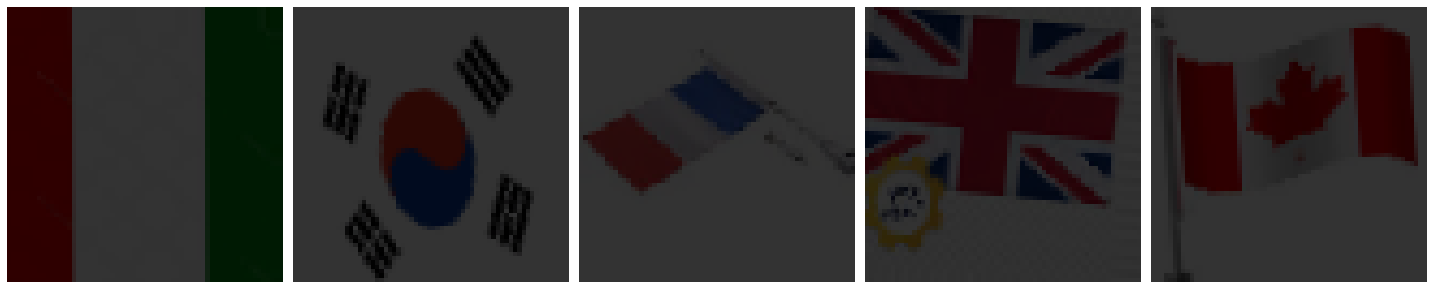

In [5]:
#옮겨 담기
sample_training_images, _ = next(trainGen)

# 이미지를 보여주는 함수
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(sample_training_images[:5])

In [6]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, Add, ReLU, AveragePooling2D
from tensorflow.keras.models import Model


def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn
    

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3):
    y = Conv2D(kernel_size=kernel_size, 
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net():
    inputs = Input(shape=(64,64,3))
    num_filters = 16
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    t = residual_block(t, downsample=True, filters=num_filters)
    num_filters *= 2
    t = residual_block(t, downsample=True, filters=num_filters)
#     t = residual_block(t, downsample=True, filters=num_filters)
#     t = residual_block(t, downsample=True, filters=num_filters)
    
    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    t = Dense(128,activation='relu')(t)
    Dropout(0.4)
    outputs = Dense(7, activation='softmax')(t)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [7]:
# model = keras.Sequential([ 
#     InputLayer(input_shape=(64,64,3)),
#     Conv2D(16, (3,3), (1,1), padding ='same', activation = 'relu'),
#     MaxPooling2D((2,2)),
#     Conv2D(16, (3,3), (1,1), padding ='same', activation = 'relu'),
#     MaxPooling2D((2,2)),
#     Conv2D(32, (3,3), (1,1), padding ='same', activation = 'relu'),
#     MaxPooling2D((2,2)),
#     Conv2D(32, (3,3), (1,1), padding ='same', activation = 'relu'),
#     MaxPooling2D((2,2)),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.4)
#     Dense(7, activation='softmax')
#     ])

# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# model.summary()

In [8]:
model = create_res_net() # or create_plain_net()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   448         batch_normalization[0][0]        
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 64, 64, 16)   0           conv2d[0][0]                     
______________________________________________________________________________________________

In [9]:
epochs = 5

history = model.fit(
    trainGen, 
    epochs=epochs,
    steps_per_epoch=trainGen.samples / epochs, 
    validation_data=validationGen,
    validation_steps=trainGen.samples / epochs,
)

# history = model.fit(trainGen, validation_data = validationGen, epochs=epochs)

Epoch 1/5
486/485 [==============================] - 529s 1s/step - loss: 0.2997 - accuracy: 0.9034 - val_loss: 0.9768 - val_accuracy: 0.8000
Epoch 2/5
486/485 [==============================] - 508s 1s/step - loss: 0.0666 - accuracy: 0.9800 - val_loss: 0.9371 - val_accuracy: 0.8535
Epoch 3/5
486/485 [==============================] - 510s 1s/step - loss: 0.0352 - accuracy: 0.9897 - val_loss: 0.7719 - val_accuracy: 0.9179
Epoch 4/5
486/485 [==============================] - 507s 1s/step - loss: 0.0238 - accuracy: 0.9931 - val_loss: 0.8726 - val_accuracy: 0.9115
Epoch 5/5
486/485 [==============================] - 508s 1s/step - loss: 0.0187 - accuracy: 0.9945 - val_loss: 0.7825 - val_accuracy: 0.8964


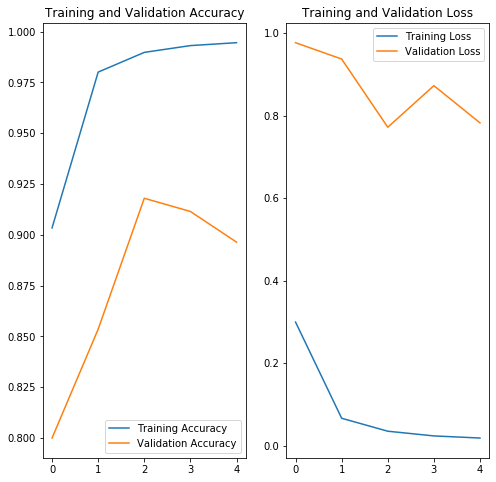

In [10]:
epochs_range = range(epochs)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_dir = os.path.join(base_dir,'test')

testGenerator = ImageDataGenerator(
    rescale=1./255
)

testGen = imageGenerator.flow_from_directory(
    test_dir,
    target_size=(64, 64),
)

# loss and accuracy
model.evaluate(testGen)

Found 199 images belonging to 7 classes.
   6502/Unknown - 624s 96ms/step - loss: 0.4562 - accuracy: 0.9009

In [ ]:
predictions = model.predict(testGen[0])

In [ ]:
predictions[0]

In [ ]:
np.argmax(predictions[0])

In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img

country_index = ['can', 'eng','fra','ger','ita','kor','usa']

In [ ]:
imgs = testGen.next()
arr = imgs[0][0]
img = array_to_img(arr).resize((128, 128))
plt.imshow(img)
result = model.predict_classes(arr.reshape(1, 64, 64, 3))
print('예측: {}'.format(country_index[result[0]]))
print('정답: {}'.format(country_index[np.argmax(imgs[1][0])]))


In [ ]:
# Visualization - incomplete
def plot_image(i, prediction, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    if prediction == true_label:
    color = 'blue'
    else:
    color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [ ]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    imgs = testGen.next()
    arr = imgs[0][0]
    img = array_to_img(arr).resize((128, 128))
    prediction = model.predict_classes(arr.reshape(1, 64, 64, 3))
    
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, country_index[result[0]],country_index[np.argmax(imgs[1][0])] , img)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_arrayplot_image(i, country_index[result[0]],country_index[np.argmax(imgs[1][0])] , img)
plt.show()